<a href="https://colab.research.google.com/github/110805/EEG_classification/blob/master/EEG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
Train epoch 90 Accuracy: 98.52%
Test epoch 90 Accuracy: 81.48%

Train epoch 90 Accuracy: 97.04%
Test epoch 90 Accuracy: 82.78%

Train epoch 90 Accuracy: 97.31%
Test epoch 90 Accuracy: 79.72%



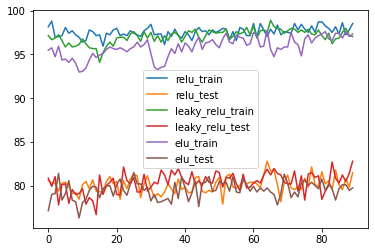

In [13]:
import dataloader 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Hyperparameter setting
batch_size = 256
learning_rate = 0.01
epochs = 90
momentum = 0.9

# Loading data
train_data, train_label, test_data, test_label = dataloader.read_bci_data()
train_data = torch.from_numpy(train_data)
train_label = torch.from_numpy(train_label)
test_data = torch.from_numpy(test_data)
test_label = torch.from_numpy(test_label)
train_loader = DataLoader(TensorDataset(train_data, train_label), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(test_data, test_label), batch_size= batch_size)

class EEGNet(nn.Module):
    def __init__(self, activation):
        super(EEGNet, self).__init__()
        if activation == 'relu':
            self.activate = nn.ReLU()
        elif activation == 'leaky':
            self.activate = nn.LeakyReLU()
        else:
            self.activate = nn.ELU()

        # firstconv
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1,51), stride=(1,1), padding=(0,25), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # depthwiseconv
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(2,1), stride=(1,1), groups=16, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avgpool1 = nn.AvgPool2d(kernel_size=(1,4), stride=(1,4), padding=0)

        # separableconv
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(1,15), stride=(1,1), padding=(0,7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.avgpool2 = nn.AvgPool2d(kernel_size=(1,8), stride=(1,8), padding=0)

        # classify
        self.linear1 = nn.Linear(736, 2, bias=True)

    def forward(self, x):
        # firstconv
        out = self.conv1(x)
        out = self.batchnorm1(out)

        # depthwiseconv
        out = self.conv2(out)
        out = self.activate(self.batchnorm2(out))
        out = F.dropout(self.avgpool1(out), p=0.25)

        # separableconv
        out = self.conv3(out)
        out = self.activate(self.batchnorm3(out))
        out = F.dropout(self.avgpool2(out), p=0.25)

        # classify
        out = out.view(-1,736)
        out = self.linear1(out)

        return out

model = [EEGNet(activation='relu'), EEGNet(activation='leaky'), EEGNet(activation='elu')]
Loss = nn.CrossEntropyLoss()


def train(epoch, model):
    model.train() # switch to train mode
    correct = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch.float())
        loss = Loss(y_pred, y_batch.long())
        loss.backward()
        optimizer.step()
        pred = torch.argmax(y_pred, dim=1)
        correct += torch.sum(pred == y_batch.int())

    if (epoch+1) == epochs:
        print('Train epoch {} Accuracy: {:.2f}%'.format(epoch+1, 100*correct.item()/len(train_label)))

    return 100*correct.item()/len(test_label)

def test(epoch, model):
    model.eval()
    correct = 0
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            y_pred = model(x_batch.float())
        
        pred = torch.argmax(y_pred, dim=1)
        correct += torch.sum(pred == y_batch.int())
    
    if (epoch+1) == epochs:
        print('Test epoch {} Accuracy: {:.2f}%'.format(epoch+1, 100*correct.item()/len(test_label)))

    return 100*correct.item()/len(test_label)

device = torch.device('cuda')
legend = ['relu_train', 'relu_test', 'leaky_relu_train', 'leaky_relu_test', 'elu_train', 'elu_test']
for i, model in enumerate(models):
    model.to(device)
    train_acc = []
    test_acc = []
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=5e-4)
    for epoch in range(epochs):
        train_acc.append(train(epoch, model))
        test_acc.append(test(epoch, model))
        #optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 200], gamma=0.1)
    
    print()
    plt.plot(range(epochs), train_acc, label=legend[2*i])
    plt.plot(range(epochs), test_acc, label=legend[2*i+1])

plt.legend(loc='best')
plt.show()